# <font color=blue>*Natural language Processing Applications - Example Codes*</font>

# *Chapter-4 $<$Name of Chapter$>$* 
## Welcome to the third notebook of Chapter-4. This notebook will give you a brief overview of text classification in MultiClass Classification setting. We will work on news classification task with 20 *different classes*. 

# **News Group Classification using <font color=blue>Support Vector Machines(SVM)</font>**

## *MultiClass classification*
MultiClass classification also known as *Multinomial Classification* is the problem of assigning the data points to Multiple Classes. In multiclass classification setting, the minimum number of classes are **3**. 
<br> 
There are few major ways these problems are learnt:
* <b>One vs Rest</b>   : Treating each "Class" as binary classificaiton problem with rest as "Other Class"
* <b>One vs One</b>    : Treating combination of "Two Class" at a time as binary classification problem
* <b>Carrmer Singer</b> : Joint optimisation over all classes at same time.

The models which support MultiClass Classificaiton are (not exhaustive):
1. Support Vector Machines (SVM)
2. Naive Bayes (NB)
3. K-Nearest Neighbours (KNN)
4. Decision Trees (All variants)
5. Neural Networks (ANN and DNN)
6. Quadratic Discriminant Analysis (QDA) and LDA
7. Learning Vector Quantization (LVQ)

More Details:
* [Wikipedia](https://en.wikipedia.org/wiki/Multiclass_classification)
* [Survey on Multiclass Classification Method](https://www.cs.utah.edu/~piyush/teaching/aly05multiclass.pdf)
* [Crammer and Singer](http://jmlr.csail.mit.edu/papers/volume2/crammer01a/crammer01a.pdf)


## News Group Data
This data is all about news feed for 20 groups of data. More details [NewGroup](http://qwone.com/~jason/20Newsgroups/)

In [1]:
# import necessary libraries
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline 

color = sns.color_palette()


### The News Group data can directly fectched using scikit-learn.


### Section 1: Load the dataset

In [2]:
from sklearn.datasets import fetch_20newsgroups

twenty_train = fetch_20newsgroups(subset='train', shuffle=True)
twenty_test = fetch_20newsgroups(subset='test', shuffle=True)

### Section 2: Explore the data

In [3]:
#lets explore the labels
labels = twenty_train.target_names 

print(labels)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


Text(0.5,0,'Occurences in dataset')

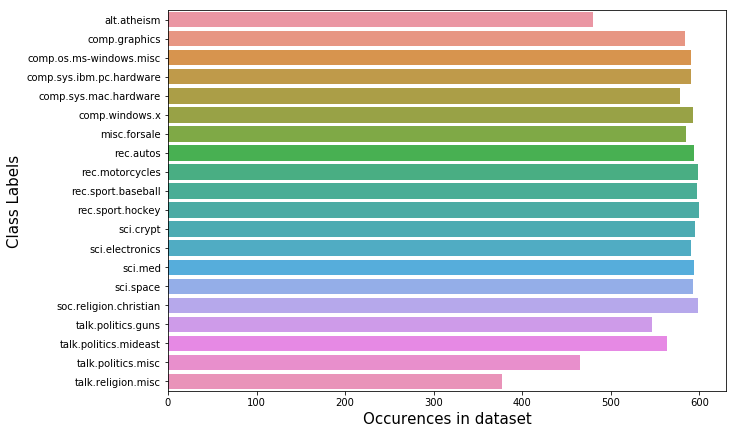

In [4]:
#Print Class Distribution
unique, counts = np.unique(twenty_train.target, return_counts=True)

plt.figure(figsize=(10,7))
sns.barplot(counts,labels)
plt.ylabel('Class Labels', fontsize=15)
plt.xlabel('Occurences in dataset', fontsize=15)

In [5]:
# print some data
print('Sample data:')
print("\n".join(twenty_train.data[0].split("\n"))) 

Sample data:
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







### Some observations after exploring the data :
* We have a total of <font color= red>**20**</font> different classes.
<br>
* Our data is in form of <font color= blue>*E-mails*</font>. 
<br>
* Data points are distributed almost evenly in every class i.e no Imbalance is there. 

### Section 3: Preprocessing of Data
In this Section we will preprocess our data. We will majorly focus on Count Vectorizer and Tfidf transformer.

<font color=blue>**CountVectorizer**</font> converts the given text into lower case, extract tokens, remove stop words and builts the Vocabulary which helps to encode the new text data.It usually works in three steps: 
* Creating an instance of CountVectorizer class.
<br>
* Fit this instance on our data, this step is responsible to create the vocabulary. 
<br>
* transform() function is reponsible to do the encoding. 

We can combine the step two and three into a single step as done below.


In [6]:
count_vect = CountVectorizer() #creating instance
X_train_counts = count_vect.fit_transform(twenty_train.data) #combined step 2 and 3
X_train_counts.shape 

(11314, 130107)

In [7]:
#print(count_vect.vocabulary_) #this will print the vocab
len(count_vect.vocabulary_)

130107

### Now that we have the count of the tokens there are tokens such as <font color=red>*'the'*</font>,<font color=red> *'is'*</font> etc... whose count value is very large as they occur frequently and that large value is also not much of use in our encoded vector. 
### Another method to get the tokens count is TF-IDF which stands for <font color=blue>**Term Frequency Inverse Document Frequency**</font>.  
* <b>Term Frequency:</b> This gives the count of each token.
* <b>Inverse Document Frequency:</b> This will downscale the words occuring more frequently.
<br> 
**Note**: TF-IDF also works in the same 3 steps as mentioned for Count Vectorizer.

In [9]:
tfidf_transformer = TfidfTransformer() #creating instance
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)#combined step 2 and 3
print(X_train_tfidf.shape)

# Processing on test data
X_test_tfidf = tfidf_transformer.transform(count_vect.transform(twenty_test.data))

(11314, 130107)



#### As we can observe its a very wide sparse matrix. We'll use this matrix as over features to train our models.


### Section 4: Creating Model
We will use Support Vector Machines algorithm to solve our classification problem.  

In [10]:
# Lets make very basic Linear SVM Classifier
clf_svm = LinearSVC(dual=False, tol=0.0001, C=1.0, multi_class='ovr',verbose=0, random_state=None, max_iter=1000)

# Fitting data on Classifier
clf_svm = clf_svm.fit(X_train_tfidf, twenty_train.target) 

In [12]:
# predict on test data
predicted = clf_svm.predict(X_test_tfidf)
print('Accuracy is:',np.mean(predicted == twenty_test.target))

Accuracy is: 0.8531598513011153


### We can see  that Accuracy is 85.13 $\%$. To explore more let's plot Confusion matrix



In [15]:
# Function to plot confusion matrix. 
# Ref:http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

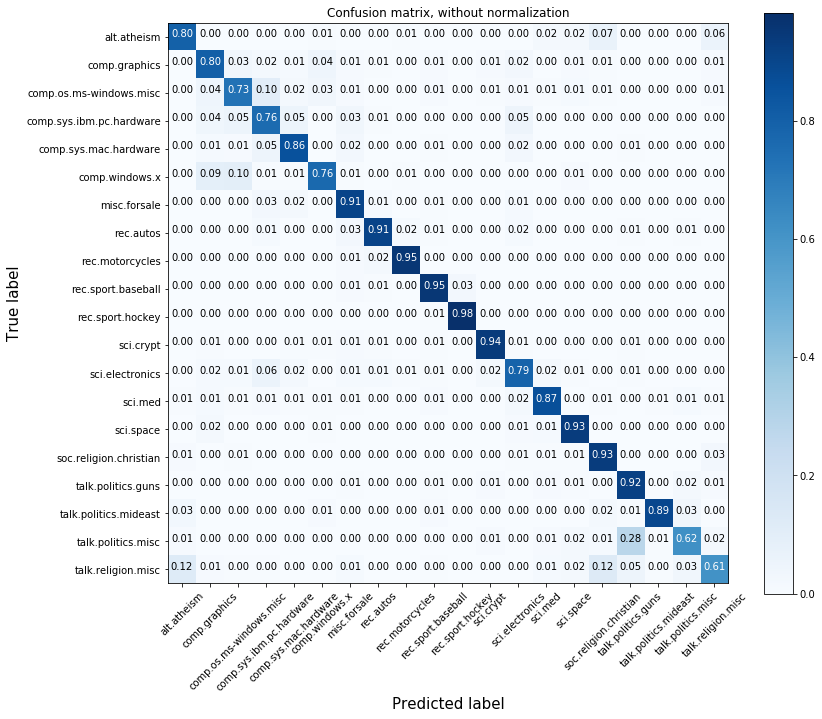

In [17]:
cnf_matrix = confusion_matrix(twenty_test.target, predicted)

plt.figure(figsize=(12,10))
plot_confusion_matrix(cnf_matrix, classes=twenty_test.target_names,normalize=True,
                      title='Confusion matrix with normalization')

In [22]:
%%time
# importing classification report
#from sklearn.metrics import classification_report

#print(classification_report(predicted,twenty_test.target))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 11.2 µs


### Section 5: Improving Model 
As from the <font color=blue>**Confusion Matrix**</font> precision of some classes is low even though the accuracy is around <font color =red> **85$\%$** </font>, so <font color = red>*"Accuracy is not a sufficient statistic for MultiClass Classificaiton Problem. We should look depeer."* </font>  
One of the reason for this may be that we have used an untuned SVM, let's try to tune the classifier and for this we will use *Grid Search* to get the right hyper-parameter value for our model.

In [23]:
# Lets create a pipeline to mke things bit easy for iterations.
# Also we'll remove stopwords from the text to reduce our corpus size as well as reduce the noise in data. 
news_clf_svm = Pipeline([('counter', CountVectorizer(stop_words='english')),
                      ('tfidf', TfidfTransformer()),
                      ('clf-svm', LinearSVC(dual=False, # As the feature space is much bigger than data
                                            class_weight='balanced', # As we have different class distribution
                                            C=10, # making the class bit more seperable
                                            verbose=1, random_state=234, max_iter=1000)) 
                         ])

In [25]:
# Now lets make a grid search to see what best works on this data set.
grid_param = {'counter__ngram_range': [(1, 1), (1, 2)],
                'tfidf__use_idf': (True, False),
                'clf-svm__multi_class': ('ovr','crammer_singer'),
                'clf-svm__tol':(1e-2, 1e-4)
             }

In [26]:
# Fitting the Data on the models generated by grid search
news_gs_clf = GridSearchCV(news_clf_svm, grid_param, n_jobs=-1,verbose=5)
news_gs_clf = news_gs_clf.fit(twenty_train.data, twenty_train.target)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] clf-svm__multi_class=ovr, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=True 
[CV] clf-svm__multi_class=ovr, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=True 
[CV] clf-svm__multi_class=ovr, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=True 
[CV] clf-svm__multi_class=ovr, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=False 
[LibLinear][CV]  clf-svm__multi_class=ovr, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=True, score=0.9178372647760403, total=  26.0s
[CV] clf-svm__multi_class=ovr, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=False 
[LibLinear][CV]  clf-svm__multi_class=ovr, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=True, score=0.9157615894039736, total=  26.8s
[CV] clf-svm__multi_class=ovr, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=False 
[LibLinear][CV]  clf-svm__multi_

[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.2min


[CV] clf-svm__multi_class=ovr, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=True 
[LibLinear][CV]  clf-svm__multi_class=ovr, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=True, score=0.9131125827814569, total= 1.2min
[CV] clf-svm__multi_class=ovr, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=True 
[LibLinear][CV]  clf-svm__multi_class=ovr, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=True, score=0.917307182613305, total= 1.2min
[CV] clf-svm__multi_class=ovr, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=False 
[LibLinear][CV]  clf-svm__multi_class=ovr, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=False, score=0.9122714020673204, total= 2.0min
[CV] clf-svm__multi_class=ovr, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=False 
[LibLinear][CV]  clf-svm__multi_class=ovr, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=False, score=0.909718534

/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=True, score=0.9125827814569536, total=  36.6s
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=True 
[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=True, score=0.9162470182878346, total=  38.3s
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=False 


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=True, score=0.9182156133828996, total=  39.4s
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=False 
[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=False, score=0.8969536423841059, total=  39.7s
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=False 


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=False, score=0.9000795123244103, total=  38.8s
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=True 
[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 1), tfidf__use_idf=False, score=0.8985661178969729, total=  50.5s
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=True 


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=ovr, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=False, score=0.9125364431486881, total= 4.2min
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=True 
[LibLinear][CV]  clf-svm__multi_class=ovr, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=False, score=0.9118428040361126, total= 4.3min
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=False 
[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=True, score=0.9210596026490067, total= 1.6min
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=False 


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=True, score=0.9234031274847602, total= 1.8min
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=False 


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=True, score=0.9214020180562932, total= 1.0min
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=True 
[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=False, score=0.9096688741721854, total=  57.6s
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=True 
[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=False, score=0.9117413199045852, total=  53.9s
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=True 


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.01, counter__ngram_range=(1, 2), tfidf__use_idf=False, score=0.9094530005310675, total=  51.8s
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=False 


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=True, score=0.9162470182878346, total= 1.5min
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=False 
[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=True, score=0.9182156133828996, total= 1.5min
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=False 
[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=False, score=0.8969536423841059, total= 1.1min
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=True 


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=False, score=0.9000795123244103, total=  47.6s
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=True 


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=False, score=0.8985661178969729, total= 1.1min
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=True 


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 1), tfidf__use_idf=True, score=0.9125827814569536, total= 3.1min
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=False 


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=True, score=0.9210596026490067, total= 3.8min
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=False 


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=True, score=0.9234031274847602, total= 4.9min
[CV] clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=False 


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=False, score=0.9096688741721854, total= 5.0min
[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=True, score=0.9214020180562932, total= 5.5min


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=False, score=0.9114762788232176, total= 3.9min


/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


[LibLinear][CV]  clf-svm__multi_class=crammer_singer, clf-svm__tol=0.0001, counter__ngram_range=(1, 2), tfidf__use_idf=False, score=0.9094530005310675, total= 2.2min


[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 27.2min finished


[LibLinear]

/home/shreyans/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:898: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [27]:
# Print the statistics                        
print(news_gs_clf.best_score_)
print(news_gs_clf.best_params_)

0.9219550998762595
{'clf-svm__multi_class': 'crammer_singer', 'clf-svm__tol': 0.01, 'counter__ngram_range': (1, 2), 'tfidf__use_idf': True}


In [34]:
# Making Prediciton
predicted = news_gs_clf.predict(twenty_test.data)
print('Accuracy:',(np.mean(predicted == twenty_test.target)))


Accuracy: 0.8601964949548593


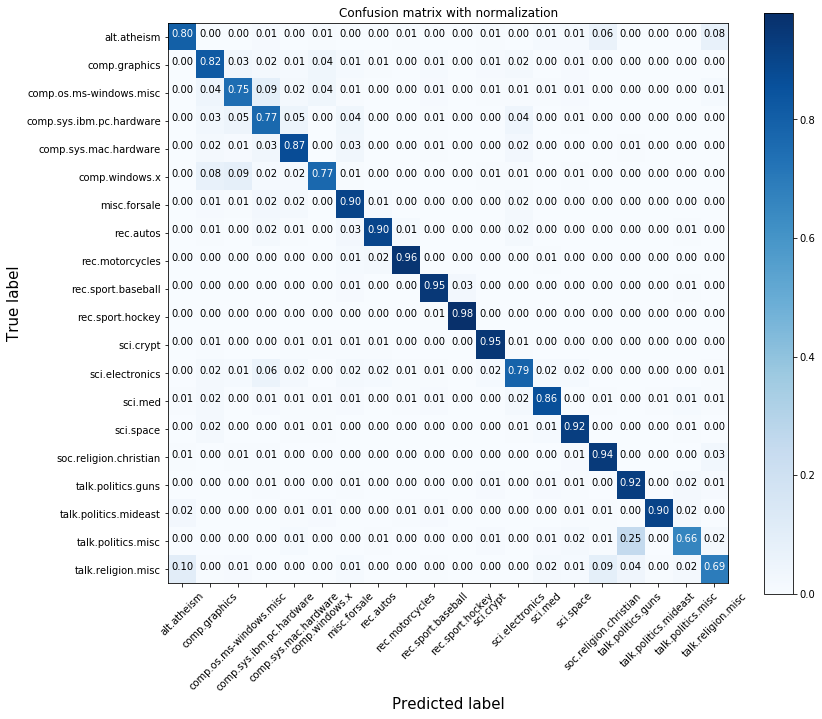

In [29]:
cnf_matrix = confusion_matrix(twenty_test.target, predicted)

plt.figure(figsize=(12,10))
plot_confusion_matrix(cnf_matrix, classes=twenty_test.target_names,normalize=True,
                      title='Confusion matrix After Grid Search')



#### As we can see class based predition has improved from the previous report.

Note: We have used whole text as one corpus. If we use same setting and do some preprocessing then we can stil get even better results. That's upto you how to do that.

In [30]:
# Also lets use Stemming, from nltk package, to data and see if it improves
stemmer = SnowballStemmer("english", ignore_stopwords=True)

# Making CountVectorizer class
class StemmedVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

stemmed_counter = StemmedVectorizer(ngram_range=(1,2), # from grid cv 
                                    stop_words='english')

In [31]:
# Now lest create pipline with parameters from grid search
news_clf = Pipeline([('counter', stemmed_counter),
                      ('tfidf', TfidfTransformer()),
                      ('clf-svm', LinearSVC(dual=False, # As the feature space is much bigger than data
                                            class_weight='balanced', # As we have different class distribution
                                            C=100, # making the class bit more seperable
                                            verbose=5, random_state=505, max_iter=1000)) 
                         ])

In [32]:
# fitting on extracted training data
news_clf= news_clf.fit(twenty_train.data, twenty_train.target)

[LibLinear]

In [35]:
# Making Prediciton on extrated testing data
predicted = news_clf.predict(twenty_test.data)
print('Accuracy: {}'.format(np.mean(predicted == twenty_test.target)))

# generating classification report
#print(classification_report(predicted,twenty_test.target))



Accuracy: 0.8586032926181625


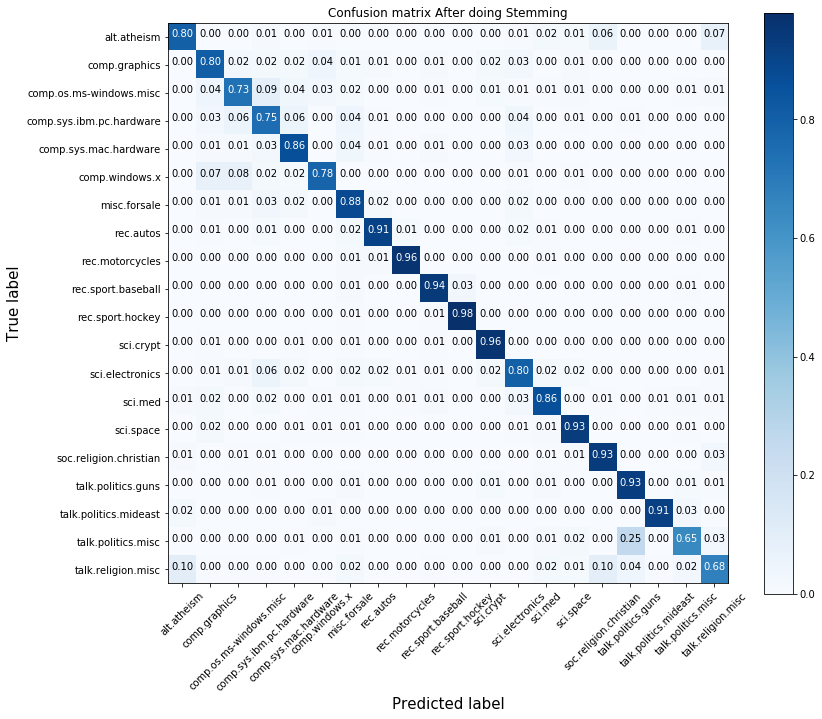

In [36]:
cnf_matrix = confusion_matrix(twenty_test.target, predicted)

plt.figure(figsize=(12,10))
plot_confusion_matrix(cnf_matrix, classes=twenty_test.target_names,normalize=True,
                      title='Confusion matrix After doing Stemming')

#### Though stemming takes longer time the effect on overall behaviour of data is less. This significantly indicates that data need lot of cleaning and processing before modelling.

### Bonus Part: Lets use Naive Bayes Classifier for the same thing

In [37]:
# A pipeline with MultinomialNB
news_clf_nb = Pipeline([('counter', CountVectorizer(ngram_range=(1,2),stop_words='english')),
                        ('tfidf', TfidfTransformer()),
                        ('clf', MultinomialNB(alpha=10.0, fit_prior=False))
                       ])

In [38]:
# fitting on NB pipeline
news_clf_nb= news_clf_nb.fit(twenty_train.data, twenty_train.target)

# Making Prediciton on extrated testing data
predicted = news_clf_nb.predict(twenty_test.data)
print('Accuracy: {}'.format(np.mean(predicted == twenty_test.target)))

# generating classification report
#print(classification_report(predicted,twenty_test.target))

Accuracy: 0.7914232607541157


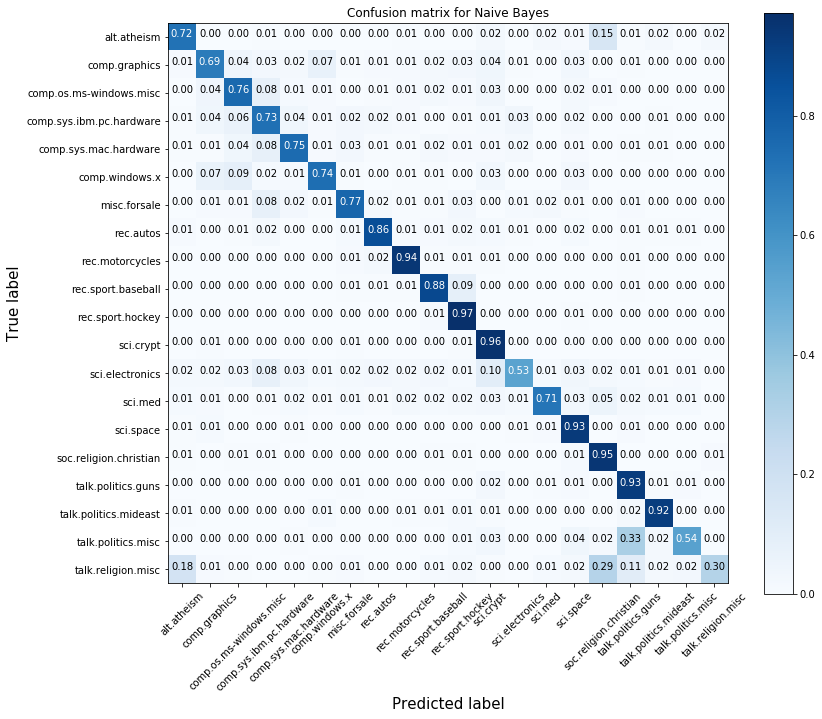

In [39]:
cnf_matrix = confusion_matrix(twenty_test.target, predicted)

plt.figure(figsize=(12,10))
plot_confusion_matrix(cnf_matrix, classes=twenty_test.target_names,normalize=True,
                      title='Confusion matrix for Naive Bayes')

#### From Confusion matrix we can see that the precision values for classes are not good so he next steps ideally inclueds the data preprocesing, feature generation and more hyperparameter tuning. 